# Evaluating Classification Models
## Credit Card Fraud Data

In [2]:
import pandas as pd

df_fraud = pd.read_csv(
    "https://datasci112.stanford.edu/data/fraud.csv")
df_fraud

card4   card6 P_emaildomain  TransactionAmt     C1     C2   C3  \
0            visa   debit     gmail.com          62.950  139.0  110.0  0.0   
1            visa   debit                        35.950    1.0    1.0  0.0   
2            visa   debit     yahoo.com         117.000    1.0    1.0  0.0   
3            visa   debit   hotmail.com          54.500    1.0    1.0  0.0   
4            visa   debit     gmail.com         255.000    1.0    3.0  0.0   
...           ...     ...           ...             ...    ...    ...  ...   
59049  mastercard   debit     gmail.com          20.522    1.0    1.0  0.0   
59050  mastercard  credit     yahoo.com          50.000    1.0    1.0  0.0   
59051  mastercard   debit    icloud.com          97.950    2.0    2.0  0.0   
59052        visa   debit     gmail.com          16.723    1.0    2.0  0.0   
59053  mastercard   debit                       107.950   24.0   21.0  0.0   

        C4     C5    C6   C7   C8    C9  C10   C11  C12    C13    C14  isFraud  
0      0.0  135.0  93.0  0.0  0.0  93.0  0.0  93.0  0.0  637.0  114.0        0  
1      0.0    1.0   0.0  0.0  0.0   1.0  0.0   1.0  0.0    3.0    1.0        0  
2      0.0    0.0   2.0  0.0  0.0   1.0  0.0   1.0  0.0    4.0    1.0        1  
3      0.0    0.0   1.0  0.0  0.0   1.0  0.0   1.0  0.0    0.0    0.0        0  
4      0.0    0.0   4.0  0.0  0.0   2.0  0.0   3.0  1.0   20.0    1.0        0  
...    ...    ...   ...  ...  ...   ...  ...   ...  ...    ...    ...      ...  
59049  1.0    0.0   1.0  1.0  1.0   0.0  1.0   1.0  1.0    1.0    1.0        0  
59050  0.0    0.0   1.0  0.0  1.0   0.0  0.0   1.0  0.0    1.0    1.0        0  
59051  0.0    1.0   2.0  0.0  0.0   1.0  0.0   2.0  0.0   15.0    2.0        0  
59052  1.0    0.0   1.0  1.0  2.0   0.0  1.0   1.0  1.0    1.0    1.0        1  
59053  0.0   14.0  13.0  0.0  0.0  17.0  0.0  18.0  0.0   84.0   17.0        0  

[59054 rows x 19 columns]

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore", sparse_output=False),
         ["card4", "card6", "P_emaildomain"]),
        remainder="passthrough"),
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5))

In [4]:
X_train = df_fraud.drop("isFraud", axis="columns")
y_train = df_fraud["isFraud"]

In [5]:
from sklearn.model_selection import cross_val_score

cross_val_score(
    pipeline,
    X=X_train, y=y_train,
    scoring="accuracy",
    cv=10
).mean()

np.float64(0.9681816450957752)

In [6]:
y_train.value_counts()

isFraud
0    56935
1     2119
Name: count, dtype: int64

# Precision and Recall
We can determine the (training) precision and recall for each class from the confusion matrix.

In [7]:
from sklearn.metrics import confusion_matrix

pipeline.fit(X_train, y_train)
y_train_ = pipeline.predict(X_train)
confusion_matrix(y_train, y_train_)

array([[56817,   118],
       [ 1524,   595]])

For example, the precision and recall for fraudulent transactions are:

precision, recall = 595 / (595 + 118), 595 / (595 + 1524)
precision, recall

And the F1-score for fraudulent transactions is the harmonic mean of these two numbers.

In [9]:
2 / (1 / precision + 1 / recall)

0.4201977401129944

There is a precision, recall, and F1 score for each class. But Scikit-Learn requires that the scoring= parameter be a single number.

For this, we can use

1. "precision_macro"
2. "recall_macro"
3. "f1_macro"
which average the score over the classes.

In [10]:
cross_val_score(
    pipeline,
    X=X_train, y=y_train,
    scoring="f1_macro",
    cv=10
).mean()

np.float64(0.647356825886165)

Precision-recall curves show the tradeoff between precision and recall.

In [12]:
y_train_probs_ = pipeline.predict_proba(X_train)
y_train_probs_

array([[1. , 0. ],
       [1. , 0. ],
       [0.6, 0.4],
       ...,
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ]])

In [13]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_train, y_train_probs_[:, 1], pos_label=1)
precision

array([0.03588241, 0.33349382, 0.63603386, 0.8345021 , 0.9278607 ,
       1.        , 1.        ])

In [16]:
import numpy as np

C:\Users\fatma\AppData\Local\Temp\ipykernel_22016\2207297004.py:5: RuntimeWarning: divide by zero encountered in divide
  "f1": 1 / (0.5 * (1 / precision + 1 / recall))


<Axes: xlabel='t', ylabel='f1'>

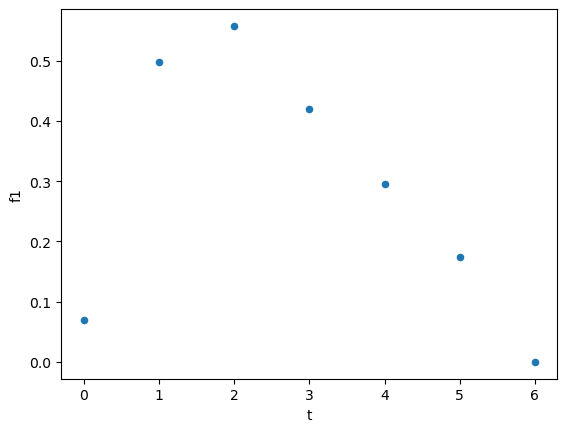

In [17]:
pd.DataFrame({
    "t": np.arange(len(precision)),
    "precision": precision,
    "recall": recall,
    "f1": 1 / (0.5 * (1 / precision + 1 / recall))
}).plot.scatter(x="t", y="f1")

C:\Users\fatma\AppData\Local\Temp\ipykernel_22016\620669146.py:5: RuntimeWarning: divide by zero encountered in divide
  "f1": 1 / (0.5 * (1 / precision + 1 / recall))


<Axes: xlabel='precision', ylabel='recall'>

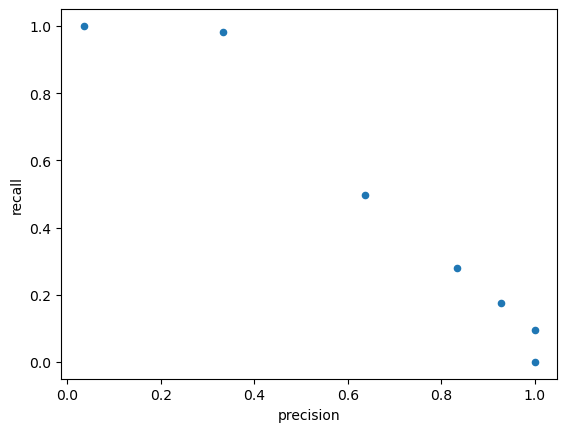

In [18]:
pd.DataFrame({
    "t": np.arange(len(precision)),
    "precision": precision,
    "recall": recall,
    "f1": 1 / (0.5 * (1 / precision + 1 / recall))
}).plot.scatter(x="precision", y="recall")